In [204]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

#distance_metrics 
def chebyshev_dist(a, b):
    return max(abs(a - b))
def cosine_dist(a, b):
    return 1 - sum(a * b) / np.sqrt(sum(a ** 2)) / np.sqrt(sum(b ** 2))
def minkowski_dist(x, y, p: int = 2):
    return sum(abs(x - y) ** p) ** (1/p)
def manhattan_dist(x, y):
    return minkowski_dist(x, y, 1)
def euclidean_dist(x, y):
    return minkowski_dist(x, y, 2)
    
distance_metrics = {
    "manhattan": manhattan_dist,
    "cosine": cosine_dist,
    "chebyshev": chebyshev_dist,
    "euclidean": euclidean_dist
}

#kernels
def rectangular(x):
    return 0.5 * (x < 1)
def triangular(x):
    return (1 - abs(x)) * (x < 1)
def epanechnikov(x):
    return (3 / 4 * (1 - x ** 2)) * (x < 1)
def bisquare(x):
    return (15/16 * (1 - x ** 2)) * (x < 1)
def gaussian(x):
    return np.exp(-0.5 * (x ** 2)) * (1 / (2 * np.pi) ** 0.5)
    
kernels = {"rectangular": rectangular, 
           "triangular": triangular, 
           "epanechnikov": epanechnikov,
           "bisquare": bisquare,
           "gaussian": gaussian}

class MyKNN:
    def __init__(self, metric_name, kernel_name, fix_size, window_p):
        if (metric_name not in distance_metrics):
            raise ValueError("Unknown metric name")
        if (kernel_name not in kernels):
            raise ValueError("Unknown kernel name")
        if (window_p is None):
            raise ValueError("Unknown H value") if fix_size else ValueError("Unknown K value")
        self.metric = distance_metrics[metric_name]
        self.kernel = kernels[kernel_name]
        self.fix_size = fix_size
        if (fix_size): 
            self.H = window_p
        else:
            self.K = window_p

    def fit(self, x, y):
        if (len(x) != len(y)):
            raise ValueError("Different number of objects and targets")
        self.x_train = x
        self.y_train = y
        self.neighbours = NearestNeighbors(metric=self.metric)
        self.neighbours.fit(x)
        
    def work_with_candidates(self, x, weights):
        if self.fix_size:
            H = np.inf if (kernel is gaussian) else self.H
            dist, ind = self.neighbours.radius_neighbors(X=np.array([x]), radius=H)
            dist = dist[0] / self.H
            ind = ind[0]
        else:
            K = self.K + 1 
            dist, ind = self.neighbours.kneighbors(X=np.array([x]), n_neighbors=K)
            dist = dist[0] / dist[0][-1]
            dist = dist[:-1]
            ind = ind[0][:-1]
        ker = self.kernel(dist) * weights[ind]
        ys = self.y_train[ind]
        categories = {}
        sum = 0
        for i in range(len(ys)):
            y = ys[i]
            if y not in categories:
                categories[y] = ker[i]
            else:
                categories[y] += ker[i]
            sum += ker[i]
        if len(categories.items()) == 0:
            raise ValueError('Radius is too small')
        return (categories, sum)
        

    def predict(self, X, w=None):
        weights = np.ones(len(self.x_train)) if (w is None) else np.array(w)
        if len(self.x_train) != len(weights):
            raise ValueError("Different number of objects and weights")
        predictions = []
        for x in X:
            categories, _ = self.work_with_candidates(x, weights)
            predictions.append(sorted(categories.items(), key=lambda x: x[1])[-1][0])
        return np.array(predictions)
    
    def predict_p_for_x(self, x, w=None):
        weights = np.ones(len(self.x_train)) if (w is None) else np.array(w)
        categories, sum = self.work_with_candidates(x, weights)
        return dict(map(lambda x: (x[0], x[1]/sum), categories.items()))
        
        


In [199]:
df = pd.read_csv('Crop_Recommendation.csv')
df

,Nitrogen,Phosphorus,Potassium,Temperature,Humidity,pH_Value,Rainfall,Crop
0,90,42,43,20.879744,82.002744,6.502985,202.935536,Rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,Rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,Rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,Rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,Rice
...,...,...,...,...,...,...,...,...
2195,107,34,32,26.774637,66.413269,6.780064,177.774507,Coffee
2196,99,15,27,27.417112,56.636362,6.086922,127.924610,Coffee
2197,118,33,30,24.131797,67.225123,6.362608,173.322839,Coffee
2198,117,32,34,26.272418,52.127394,6.758793,127.175293,Coffee


In [200]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
scaler = StandardScaler()
X = scaler.fit_transform(df.drop(columns=['Crop']))
y = df['Crop']

X_train, X_test, y_train, y_test = train_test_split(X, y.to_numpy(), test_size=0.2)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

In [201]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

n_neighbour = 20
my_knn = MyKNN("euclidean", "rectangular", False, n_neighbour)
my_knn.fit(X_train, y_train)
pred_my = my_knn.predict(X_test)
print("My KNN accuracy: ", accuracy_score(y_test, pred_my))

lib_knn = KNeighborsClassifier(n_neighbors=n_neighbour, metric=euclidean_dist)
lib_knn.fit(X_train, y_train)
pred_lib = lib_knn.predict(X_test)
print("Lib KNN accuracy: ", accuracy_score(y_test, pred_lib))

My KNN accuracy:  0.925
Lib KNN accuracy:  0.9272727272727272


In [172]:
import optuna, tqdm
def find_parameters_my(trial):
    metric = trial.suggest_categorical('metric', list(distance_metrics.keys()))
    kernel = trial.suggest_categorical("kernel", list(kernels.keys()))
    fix_size = trial.suggest_categorical('fix_size', [True, False])
    if fix_size:
        window_p = trial.suggest_float("H", 15, 500)
    else:
        window_p = trial.suggest_int("K", 1, 500)
    model = MyKNN(metric, kernel, fix_size, window_p)
    model.fit(X_train, y_train)
    pred = model.predict(X_valid)
    return 0 if pred is None else accuracy_score(y_valid, pred)

study = optuna.create_study(direction="maximize")
study.optimize(find_parameters_my, n_trials=50)
print("Best value (My KNN): ", study.best_value)
print("Best parameters (My KNN): ", study.best_params)

[I 2024-05-23 04:22:52,224] A new study created in memory with name: no-name-06096720-55bc-494f-9b2f-4c33e3e59769
[I 2024-05-23 04:23:00,138] Trial 0 finished with value: 0.07670454545454546 and parameters: {'metric': 'manhattan', 'kernel': 'bisquare', 'fix_size': True, 'H': 279.57680274239095}. Best is trial 0 with value: 0.07670454545454546.
[I 2024-05-23 04:23:04,807] Trial 1 finished with value: 0.7045454545454546 and parameters: {'metric': 'euclidean', 'kernel': 'rectangular', 'fix_size': False, 'K': 190}. Best is trial 1 with value: 0.7045454545454546.
[I 2024-05-23 04:23:09,344] Trial 2 finished with value: 0.8011363636363636 and parameters: {'metric': 'manhattan', 'kernel': 'rectangular', 'fix_size': False, 'K': 148}. Best is trial 2 with value: 0.8011363636363636.
[I 2024-05-23 04:23:14,145] Trial 3 finished with value: 0.07670454545454546 and parameters: {'metric': 'manhattan', 'kernel': 'gaussian', 'fix_size': True, 'H': 437.75626076753014}. Best is trial 2 with value: 0.801

Best value (My KNN):  0.9801136363636364
Best parameters (My KNN):  {'metric': 'euclidean', 'kernel': 'gaussian', 'fix_size': False, 'K': 3}


In [173]:
def optim_lib(trial):
    K = trial.suggest_int("K", 1, 500)
    metric = trial.suggest_categorical('metric',  list(distance_metrics.values()))
    model = KNeighborsClassifier(K, metric=metric)
    model.fit(X_train, y_train)
    pred_lib = model.predict(X_valid)
    return accuracy_score(y_valid, pred_lib)

study = optuna.create_study(direction="maximize")
study.optimize(optim_lib, n_trials=25)
print("Best value (Lib KNN): ", study.best_value)
print("Best parameters (Lib KNN): ", study.best_params)

[I 2024-05-23 04:27:34,644] A new study created in memory with name: no-name-a80e4a31-af80-4fce-950c-d5072c5703bd
[I 2024-05-23 04:27:41,081] Trial 0 finished with value: 0.6704545454545454 and parameters: {'K': 218, 'metric': <function manhattan_dist at 0x00000213C2A7AD40>}. Best is trial 0 with value: 0.6704545454545454.
[I 2024-05-23 04:27:44,300] Trial 1 finished with value: 0.3494318181818182 and parameters: {'K': 452, 'metric': <function chebyshev_dist at 0x00000213C4106F20>}. Best is trial 0 with value: 0.6704545454545454.
[I 2024-05-23 04:27:52,386] Trial 2 finished with value: 0.5028409090909091 and parameters: {'K': 280, 'metric': <function cosine_dist at 0x00000213C4107F60>}. Best is trial 0 with value: 0.6704545454545454.
[I 2024-05-23 04:27:56,531] Trial 3 finished with value: 0.6704545454545454 and parameters: {'K': 218, 'metric': <function manhattan_dist at 0x00000213C2A7AD40>}. Best is trial 0 with value: 0.6704545454545454.
[I 2024-05-23 04:27:59,274] Trial 4 finished 

Best value (Lib KNN):  0.9744318181818182
Best parameters (Lib KNN):  {'K': 5, 'metric': <function euclidean_dist at 0x00000213C4105620>}


100%|██████████| 10/10 [02:29<00:00, 14.90s/it]


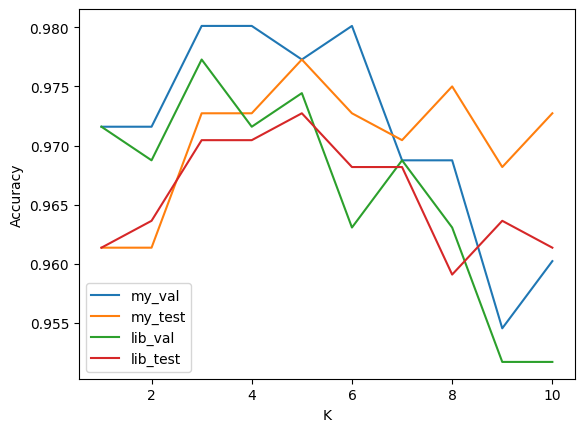

In [178]:
K = 11
ks = range(1, K)
my_val, my_test, lib_val, lib_test = [0] * (K - 1), [0] * (K - 1), [0] * (K - 1), [0] * (K - 1)
for k in tqdm.tqdm(ks):
    model = MyKNN("euclidean", "gaussian", False, k)
    model.fit(X_train, y_train)
    my_pred_val = model.predict(X_valid)
    my_pred_test = model.predict(X_test)
    my_val[k - 1] = accuracy_score(y_valid, my_pred_val)
    my_test[k - 1] = accuracy_score(y_test, my_pred_test)

    model = KNeighborsClassifier(k, metric=euclidean_dist)
    model.fit(X_train, y_train)
    lib_pred_val = model.predict(X_valid)
    lib_pred_test = model.predict(X_test)
    lib_val[k - 1] = accuracy_score(y_valid, lib_pred_val)
    lib_test[k - 1] = accuracy_score(y_test, lib_pred_test)

plt.plot(list(ks), my_val, label="my_val")
plt.plot(list(ks), my_test, label="my_test")
plt.plot(list(ks), lib_val, label='lib_val')
plt.plot(list(ks), lib_test, label='lib_test')
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.legend()


In [210]:
def lowess(X, y, kernel):
    result_weights = [0.0] * len(X)
    for i in range(X.shape[0]):
        model = MyKNN("euclidean", "gaussian", False, 3)
        model.fit(np.concatenate((X[:i], X[i + 1:])), np.delete(y, i))
        prob = model.predict_p_for_x(X[i]).get(y[i], 0.0)
        result_weights[i] = kernel(prob)
    return result_weights

model = MyKNN("euclidean", "gaussian", False, 3)
model.fit(X_train, y_train)
print("Without using weights: ", 
      "\nval: ", accuracy_score(y_valid, model.predict(X_valid)), 
      "\ntest: ", accuracy_score(y_test, model.predict(X_test)), "\n\n")
for kernel_name in list(kernels.keys()):
    weights = lowess(X_train, y_train, kernels[kernel_name])
    print("Using ", kernel_name, ": ", 
          "\nval: ", accuracy_score(y_valid, model.predict(X_valid, w=weights)), 
          "\ntest: ", accuracy_score(y_test, model.predict(X_test, w=weights)), "\n\n")

Without using weights:  
val:  0.9744318181818182 
test:  0.9795454545454545 


Using  rectangular :  
val:  0.9545454545454546 
test:  0.9659090909090909 


Using  triangular :  
val:  0.9488636363636364 
test:  0.9613636363636363 


Using  epanechnikov :  
val:  0.9517045454545454 
test:  0.9590909090909091 


Using  bisquare :  
val:  0.9517045454545454 
test:  0.9590909090909091 


Using  gaussian :  
val:  0.9744318181818182 
test:  0.9818181818181818 




In [214]:
def get_indexes(X, y, kernel):
    taken_indexes = []
    for i in range(X.shape[0]):
        model = MyKNN("euclidean", "gaussian", False, 3)
        model.fit(np.concatenate((X[:i], X[i + 1:])), np.delete(y, i))
        prob = model.predict_p_for_x(X[i]).get(y_train[i], 0.0)
        if kernel(prob) > 0.1:
            taken_indexes.append(i)
    return taken_indexes

model = KNeighborsClassifier(n_neighbors=5, metric=euclidean_dist)
model.fit(X_train, y_train)
print("Without using weights: ", 
      "\nval: ", accuracy_score(y_valid, model.predict(X_valid)), 
       "\ntest: ", accuracy_score(y_test, model.predict(X_test)), "\n\n"
      )

for kernel_name in list(kernels.keys()):
    indexes = get_indexes(X_train, y_train, kernels[kernel_name])
    model = KNeighborsClassifier(n_neighbors=5, metric=euclidean_dist)
    model.fit(X_train[indexes], y_train[indexes])
    print("Using ", kernel_name, ": ", 
        "\nval: ", accuracy_score(y_valid, model.predict(X_valid)), 
        "\ntest: ", accuracy_score(y_test, model.predict(X_test)), "\n\n")

Without using weights:  
val:  0.9602272727272727 
test:  0.975 


Using  rectangular :  
val:  0.3806818181818182 
test:  0.3704545454545455 


Using  triangular :  
val:  0.3806818181818182 
test:  0.3704545454545455 


Using  epanechnikov :  
val:  0.3806818181818182 
test:  0.3704545454545455 


Using  bisquare :  
val:  0.3806818181818182 
test:  0.3704545454545455 


Using  gaussian :  
val:  0.9602272727272727 
test:  0.975 


